In [1]:
import json
from google.colab import drive
import librosa
from transformers import WhisperForConditionalGeneration, AutoProcessor


import torch
import torch.nn as nn
import numpy as np
import json
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, jaccard_score, matthews_corrcoef, hamming_loss
from sklearn.preprocessing import LabelBinarizer
import os
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
from datetime import datetime

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

In [ ]:
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# torgo_embeddings_path = os.path.join(parent_dir, "/content/drive/My Drive/CSE/Year 3/ResearchProject/Dataset/TORGO_Embeddings_Mirella_Cut_New.json")
torgo_embeddings_path = os.path.join(parent_dir, "/content/drive/My Drive/CSE/Year 3/ResearchProject/Dataset/TORGO_Embeddings_Normal_Cut_New.json")

# embeddings_path = os.path.join(parent_dir, "Embeddings_5.5Seconds.json")
# Local Dataset
# current_dir = os.getcwd()
# parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# embeddings_path = os.path.join(parent_dir, "Embeddings_5.5Seconds.json")


with open(torgo_embeddings_path, 'r') as f:
    data = json.load(f)

torgo_file_names = [entry['fileName'] for entry in data]
torgo_numpy_arrays = [np.array(entry['numpyArray']) for entry in data]

# class_names = []
# tensor_arrays_balanced = []

# for i, file_name in enumerate(torgo_file_names):
#     if ('MC01' in file_name or 'FCO1' in file_name or 'MC04/Session2' in file_name):
#         class_names.append('Healthy')
#     elif ('F04' in file_name or 'M03' in file_name):
#         class_names.append('VeryLow')
#     elif ('F01' in file_name or 'M05' in file_name or 'F03/Session2' in file_name or 'F03/Session3' in file_name ):
#         class_names.append('Low')
#     elif ('M01' in file_name or 'M01' in file_name or 'M02' in file_name or 'M04' in file_name):
#         class_names.append('Medium')



In [ ]:
class_names = []

for i, file in enumerate(torgo_file_names):
  if ('MC01' in file or 'FCO1' in file or 'MC04/Session1' in file):
      class_names.append('Healthy')
  elif ('F04' in file or 'M03' in file):
      class_names.append('VeryLow')
  elif ('M05' in file or 'F03' in file ):
      class_names.append('Low')
  elif ('F01' in file or 'M01' in file
        or 'M02' in file or 'M04' in file):
      class_names.append('Medium')

In [ ]:
unique_class_names = ['Healthy', 'VeryLow', 'Low', 'Medium']
class_to_number = {class_name: i for i, class_name in enumerate(unique_class_names)}
torgo_class_numbers = [class_to_number[name] for name in class_names]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Example data: assuming you have n_samples
# tensor_arrays: list of tensors, each of shape (1280, 40)
# y: your class labels of shape (n_samples,)
# Replace these with your actual data variables

# Convert the list of tensors to a NumPy array
# tensor_arrays = [tensor.numpy() for tensor in tensor_arrays]  # If tensors are PyTorch tensors
# tensor_arrays = np.array(tensor_arrays)  # Now tensor_arrays is a NumPy array of shape (n_samples, 1280, 40)

numpy_arrays = np.array(torgo_numpy_arrays)
# cut_numpy_array = numpy_arrays[:, :30, :]
# [:, :10, :]

print(numpy_arrays.shape)
result = np.mean(numpy_arrays, axis=1)
print(type(result))
# Flatten the 2D array to 1D
n_samples = result.shape[0]
X_flattened = result.flatten()

print(result.shape)

reshaped = result.reshape(n_samples, -1)
# # umpy_arrays.reshape(n_samples, -1)
#
#   # shape (n_samples, 1280*40)

# # Standardize the data
# scaler = StandardScaler()
# X_flattened = result
# print(X_flattened.shape)
X_scaled = reshaped
# scaler.fit_transform(reshaped)

(3672, 125, 1280)
<class 'numpy.ndarray'>
(3672, 1280)


Shape of PCA result: (3672, 2)


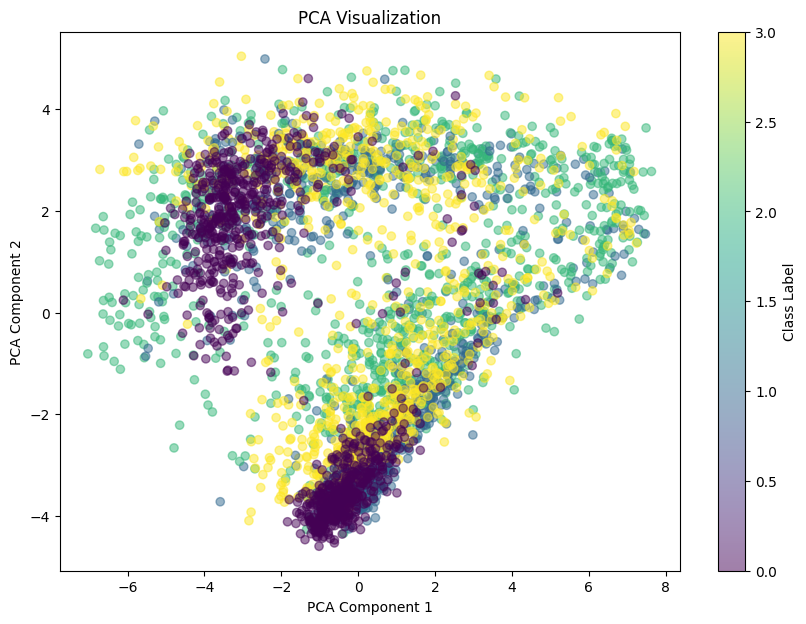

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
print("Shape of PCA result:", pca_result.shape)

# Plot PCA result
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c= torgo_class_numbers, cmap='viridis', alpha=0.5)
plt.colorbar(label='Class Label')
plt.title('PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [4]:
from sklearn.manifold import TSNE

Shape of t-SNE result: (3672, 2)


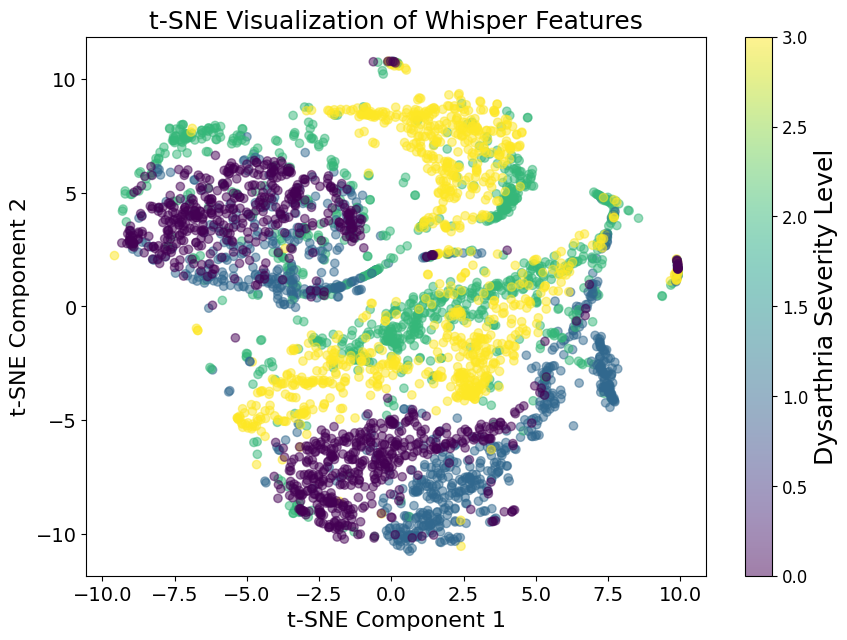

In [ ]:
# Perform t-SNE on the original data (optional, can be done on PCA result too)
# tsne = TSNE(n_components=2, perplexity=30, n_iter=350)
# tsne_result = tsne.fit_transform(X_scaled)
# print("Shape of t-SNE result:", tsne_result.shape)

# # Plot t-SNE result

# # torgo_class_numbers
# plt.figure(figsize=(10, 7))
# plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c= torgo_class_numbers, cmap='viridis', alpha=0.5)
# plt.colorbar(label='Class Label')
# plt.title('t-SNE Visualization of fine-tuned MG Whisper Features')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.show()

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(X_scaled)
print("Shape of t-SNE result:", tsne_result.shape)

# Plot t-SNE result

# torgo_class_numbers
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c= torgo_class_numbers, cmap='viridis', alpha=0.5)
cbar = plt.colorbar(scatter)
cbar.set_label('Dysarthria Severity Level', fontsize=18)
cbar.ax.tick_params(labelsize=12)  # Change the font size of the color bar labels
plt.title('t-SNE Visualization of Whisper Features', fontsize=18)
plt.xlabel('t-SNE Component 1', fontsize=16)
plt.ylabel('t-SNE Component 2', fontsize=16)
plt.xticks(fontsize=14)  # Change the font size of the x-axis tick labels
plt.yticks(fontsize=14)  # Change the font size of the y-axis tick labels
plt.show()

In [5]:
import librosa
import numpy as np
import os
from transformers import WhisperForConditionalGeneration, AutoProcessor
import torch
import librosa
from tqdm import tqdm
from pathlib import Path
import json
import numpy as np
import time
import wave

In [7]:
data_folder = '/content/drive/My Drive/CSE/Year 3/ResearchProject/Dataset/TORGO'

def get_wav_duration(file_path):
    with wave.open(file_path, 'r') as wav_file:
        frames = wav_file.getnframes()
        rate = wav_file.getframerate()
        duration = frames / float(rate)
    return duration

def find_wav_files(directory):
    wav_files = []
    # Iterate over all items (files and directories) in the current directory
    for item in os.listdir(directory):
        # Construct the full path
        item_path = os.path.join(directory, item)
        # If it's a file and ends with .wav, and there's no 'C' in the path, and duration is longer than 2 seconds, add it to the list
        if os.path.isfile(item_path) and item.lower().endswith(".wav"):
            if get_wav_duration(item_path) > 2.5:
                file = item_path
                if ('MC01' in file or 'FCO1' in file or 'MC04/Session1' in file or 'F04' in file or
                'M03' in file or 'F01' in file or 'M05' in file or 'F03' in file or
                'F03/Session3' in file or 'M01' in file or 'M02' in file or 'M04' in file):

  #               for i, file in enumerate(torgo_file_names):
  # if ('MC01' in file or 'FCO1' in file or 'MC04/Session1' in file):
  #     class_names.append('Healthy')
  # elif ('F04' in file or 'M03' in file):
  #     class_names.append('VeryLow')
  # elif ('M05' in file or 'F03' in file ):
  #     class_names.append('Low')
  # elif ('F01' in file or 'M01' in file
  #       or 'M02' in file or 'M04' in file):
                    # class_names.append('Medium')
                    wav_files.append(item_path)
        # If it's a directory, recursively call the function
        elif os.path.isdir(item_path):
            wav_files.extend(find_wav_files(item_path))
    return wav_files

wav_files = find_wav_files(data_folder)
print(len(wav_files))

3672


In [8]:
class_names_mfcc = []

for i, file in enumerate(wav_files):
  if ('MC01' in file or 'FCO1' in file or 'MC04/Session1' in file):
      class_names_mfcc.append('Healthy')
  elif ('F04' in file or 'M03' in file):
      class_names_mfcc.append('VeryLow')
  elif ('M05' in file or 'F03' in file ):
      class_names_mfcc.append('Low')
  elif ('F01' in file or 'M01' in file
        or 'M02' in file or 'M04' in file):
      class_names_mfcc.append('Medium')

In [9]:
unique_class_names = ['Healthy','VeryLow', 'Low',  'Medium']
class_to_number = {class_name: i for i, class_name in enumerate(unique_class_names)}
class_numbers_mfcc = [class_to_number[name] for name in class_names_mfcc]

In [10]:
MFCCs = []

for i, file_path in enumerate(wav_files):
  y, sr = librosa.load(file_path)
  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
  MFCCs.append(np.array(mfccs))
  print(i)

# MFCCs = np.array(MFCCs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [11]:
MFCCs_cut = []

for elem in MFCCs:
  MFCCs_cut.append(elem[:, :100])

MFCCs_cut_numpy = np.array(MFCCs_cut)

In [15]:
# numpy_arrays = np.array(torgo_numpy_arrays)
# # cut_numpy_array = numpy_arrays[:, :30, :]
# # [:, :10, :]

from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# print(numpy_arrays.shape)
averaged_mfcc = np.mean(MFCCs_cut_numpy, axis=1)
# print(type(result))
# Flatten the 2D array to 1D
n_samples = averaged_mfcc.shape[0]
X_mfcc_flattened = averaged_mfcc.flatten()

# print(result.shape)

reshaped_mfcc = averaged_mfcc.reshape(n_samples, -1)
# # umpy_arrays.reshape(n_samples, -1)
#
#   # shape (n_samples, 1280*40)

# # Standardize the data
scaler = StandardScaler()
# X_flattened = result
# print(X_flattened.shape)
X_scaled_mfcc = reshaped_mfcc
# scaler.fit_transform(reshaped_mfcc)

Shape of PCA result: (3672, 2)


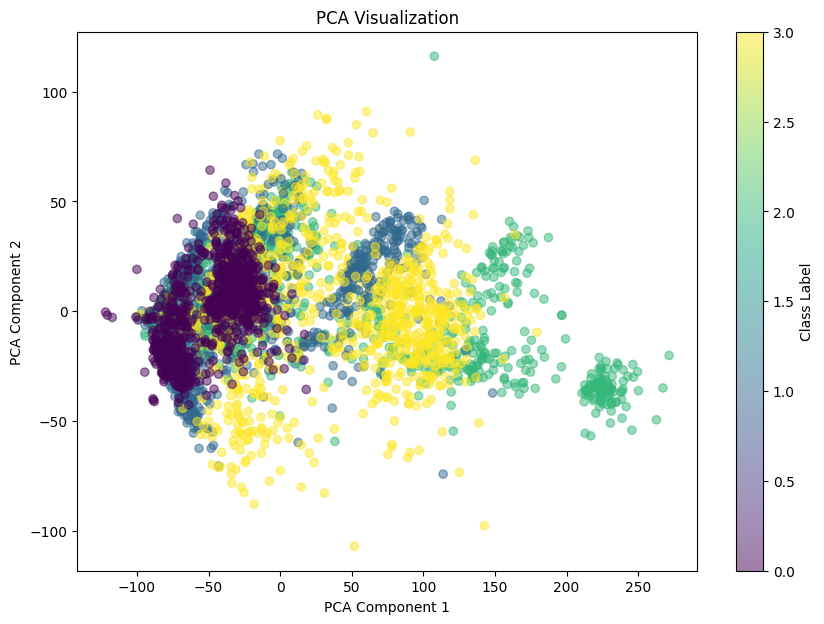

In [16]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled_mfcc)
print("Shape of PCA result:", pca_result.shape)

# Plot PCA result
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c= class_numbers_mfcc, cmap='viridis', alpha=0.5)
plt.colorbar(label='Class Label')
plt.title('PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

Shape of t-SNE result: (3672, 2)


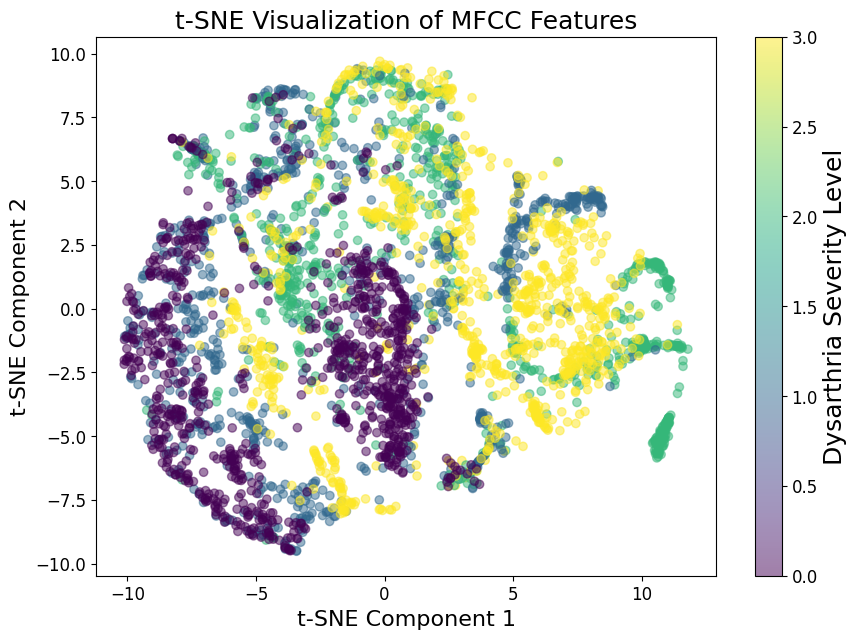

In [20]:
# Perform t-SNE on the original data (optional, can be done on PCA result too)
# tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
# tsne_result = tsne.fit_transform(X_scaled_mfcc)
# print("Shape of t-SNE result:", tsne_result.shape)

# # Plot t-SNE result
# plt.figure(figsize=(10, 7))
# plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c= class_numbers_mfcc, cmap='viridis', alpha=0.5)
# plt.colorbar(label='Class Label')
# plt.title('t-SNE Visualization of MFCC features')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.show()

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(X_scaled_mfcc)
print("Shape of t-SNE result:", tsne_result.shape)

# Plot t-SNE result
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=class_numbers_mfcc, cmap='viridis', alpha=0.5)
cbar = plt.colorbar(scatter)
cbar.set_label('Dysarthria Severity Level', fontsize=18)
cbar.ax.tick_params(labelsize=12)  # Change the font size of the color bar labels
plt.title('t-SNE Visualization of MFCC Features', fontsize=18)
plt.xlabel('t-SNE Component 1', fontsize=16)
plt.ylabel('t-SNE Component 2', fontsize=16)
plt.xticks(fontsize=12)  # Change the font size of the x-axis tick labels
plt.yticks(fontsize=12)  # Change the font size of the y-axis tick labels
plt.show()